<a href="https://colab.research.google.com/github/B-Deforce/tiktok_vids/blob/main/cat_vs_dogs_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cat vs. Dog classifier

Based on [this](https://www.tensorflow.org/tutorials/images/classification) Tensorflow-tutorial

## Import TensorFlow and other libraries

In [1]:
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import os

import tensorflow as tf
import glob
import random
import shutil

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from google.colab import files

In [41]:
# basic file uploader to upload images to Google colab
uploaded = files.upload()

Saving cat.PNG to cat.PNG


In [2]:
# for Kaggle API key
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 67 bytes


In [3]:
import kaggle

## Download and explore the dataset

Download [dogs_vs_cats dataset](https://www.kaggle.com/biaiscience/dogs-vs-cats) from Kaggle

In [4]:
# command for downloading data directly from Kaggle
!kaggle datasets download -d biaiscience/dogs-vs-cats

 98% 801M/817M [00:24<00:00, 21.7MB/s]
100% 817M/817M [00:24<00:00, 34.4MB/s]


In [ ]:
# unzip
!unzip dogs-vs-cats.zip

After downloading, you should now have a copy of the dataset available.

In [6]:
# count available images for each class and for test + train set
for i in ["dog", "cat"]:
  image_count = len(list(glob.glob(f'train/train/{i}*.jpg')))
  print(f"# train {i}s: {image_count}")

test_count = len(list(glob.glob(f'test/test/*.jpg')))
print(f"# test images: {test_count}")

# train dogs: 12500
# train cats: 12500
# test images: 12500


# Reorganize directories

In [7]:
# create directories
dataset_home = 'dataset_dogs_vs_cats/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['dogs/', 'cats/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		os.makedirs(newdir, exist_ok=True)

In [8]:
# seed random number generator
random.seed(123)
# define ratio of pictures to use for validation
val_ratio = 0.20
# copy training dataset images into subdirectories
src_directory = 'train/train/'
for file in os.listdir(src_directory):
	src = src_directory + '/' + file
	dst_dir = 'train/'
	if random.random() < val_ratio:
		dst_dir = 'test/'
	if file.startswith('cat'):
		dst = dataset_home + dst_dir + 'cats/'  + file
		shutil.copyfile(src, dst)
	elif file.startswith('dog'):
		dst = dataset_home + dst_dir + 'dogs/'  + file
		shutil.copyfile(src, dst)

# Load data using a Keras utility

Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

Note that one could also use a `tf.keras.preprocessing.image.ImageDataGenerator`. Regardless, this generates an `Iterator` which is less performant than a `tf.data.Dataset`.


## Create a dataset

Define some parameters for the loader:

In [9]:
batch_size = 32
img_height = 200
img_width = 200

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_home + '/train',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 19945 files belonging to 2 classes.


In [12]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_home + '/test',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5055 files belonging to 2 classes.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [13]:
class_names = train_ds.class_names
print(class_names)

['cats', 'dogs']


## Visualize the data

Here are the first nine images from the training dataset:

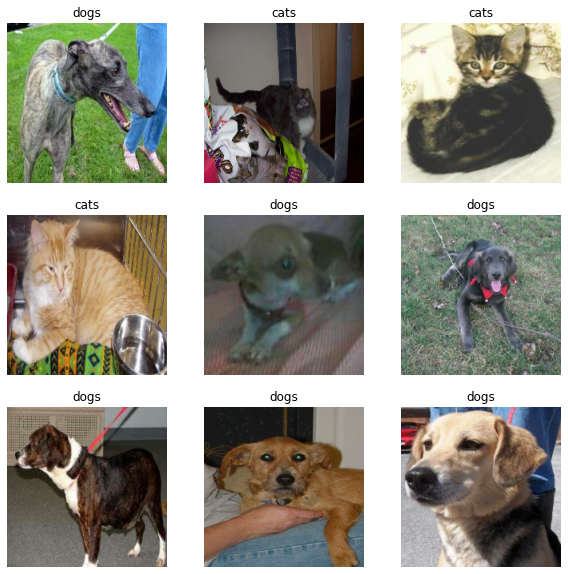

In [14]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will train a model using these datasets by passing them to `Model.fit` in a moment. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [15]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 200, 200, 3)
(32,)


The `image_batch` is a tensor of the shape `(32, 200, 200, 3)`. This is a batch of 32 images of shape `200x200x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


# Create the model

The [Sequential](../../guide/keras/sequential_model.ipynb) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy—the goal of this tutorial is to show a standard approach.

In [ ]:
num_classes = 2

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)), # note the rescaling layer to rescale each pixel to the [0.,1.] interval
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Model summary

View all the layers of the network using the model's `Model.summary` method:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 64)        0

## Train the model

In [ ]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
624/624 [==============================] - 86s 88ms/step - loss: 0.6142 - accuracy: 0.6527 - val_loss: 0.5323 - val_accuracy: 0.7385
Epoch 2/10
624/624 [==============================] - 50s 79ms/step - loss: 0.4680 - accuracy: 0.7750 - val_loss: 0.4839 - val_accuracy: 0.7731
Epoch 3/10
624/624 [==============================] - 50s 80ms/step - loss: 0.3959 - accuracy: 0.8181 - val_loss: 0.4398 - val_accuracy: 0.7968
Epoch 4/10
624/624 [==============================] - 50s 80ms/step - loss: 0.3171 - accuracy: 0.8603 - val_loss: 0.5008 - val_accuracy: 0.7893
Epoch 5/10
624/624 [==============================] - 50s 80ms/step - loss: 0.2251 - accuracy: 0.9050 - val_loss: 0.6639 - val_accuracy: 0.7891
Epoch 6/10
624/624 [==============================] - 50s 79ms/step - loss: 0.1554 - accuracy: 0.9373 - val_loss: 0.7220 - val_accuracy: 0.7915
Epoch 7/10
624/624 [==============================] - 50s 79ms/step - loss: 0.1016 - accuracy: 0.9613 - val_loss: 0.9544 - val_accuracy:

## Visualize training results

Create plots of loss and accuracy on the training and validation sets:

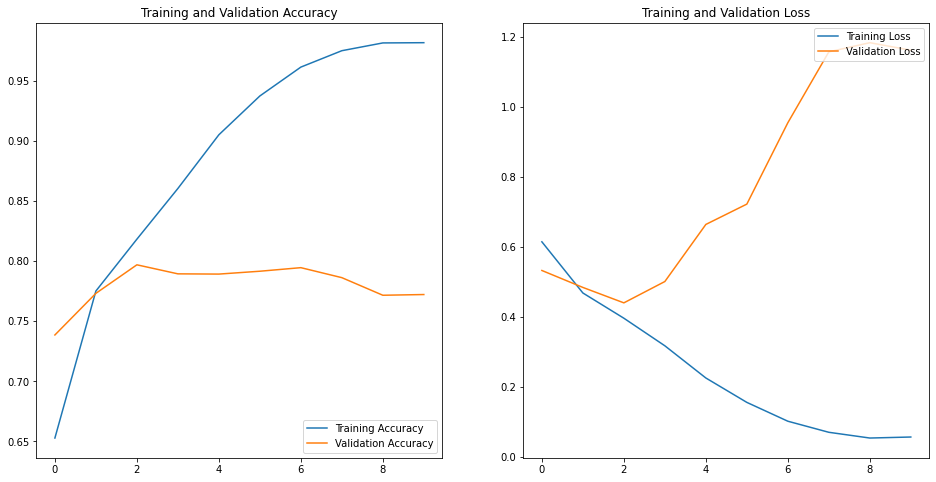

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

We observe that the model is overfitting due to the large gap between training-set performance and validation-set performance. This same behavior is observed in the loss on the right-hand side

## Dropout

We reduce overfitting by applying [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization) regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Let's create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

# Define the model

In [18]:
model = Sequential([
#  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile and train the model

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [22]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15
624/624 [==============================] - 81s 80ms/step - loss: 0.6050 - accuracy: 0.6559 - val_loss: 0.5198 - val_accuracy: 0.7363
Epoch 2/15
624/624 [==============================] - 50s 80ms/step - loss: 0.4838 - accuracy: 0.7621 - val_loss: 0.5270 - val_accuracy: 0.7385
Epoch 3/15
624/624 [==============================] - 50s 79ms/step - loss: 0.4135 - accuracy: 0.8072 - val_loss: 0.4173 - val_accuracy: 0.8057
Epoch 4/15
624/624 [==============================] - 50s 79ms/step - loss: 0.3407 - accuracy: 0.8480 - val_loss: 0.4245 - val_accuracy: 0.8156
Epoch 5/15
624/624 [==============================] - 50s 79ms/step - loss: 0.2588 - accuracy: 0.8905 - val_loss: 0.4673 - val_accuracy: 0.8030
Epoch 6/15
624/624 [==============================] - 50s 79ms/step - loss: 0.1828 - accuracy: 0.9267 - val_loss: 0.5576 - val_accuracy: 0.8014
Epoch 7/15
624/624 [==============================] - 50s 80ms/step - loss: 0.1432 - accuracy: 0.9441 - val_loss: 0.7691 - val_accuracy:

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 200, 200, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 50, 50, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 25, 25, 64)       

In [ ]:
# save the model to Google drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
model.save('drive/MyDrive/cat_vs_dog')

In [ ]:
# reload the model
model = keras.models.load_model('drive/MyDrive/cat_vs_dog')

## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

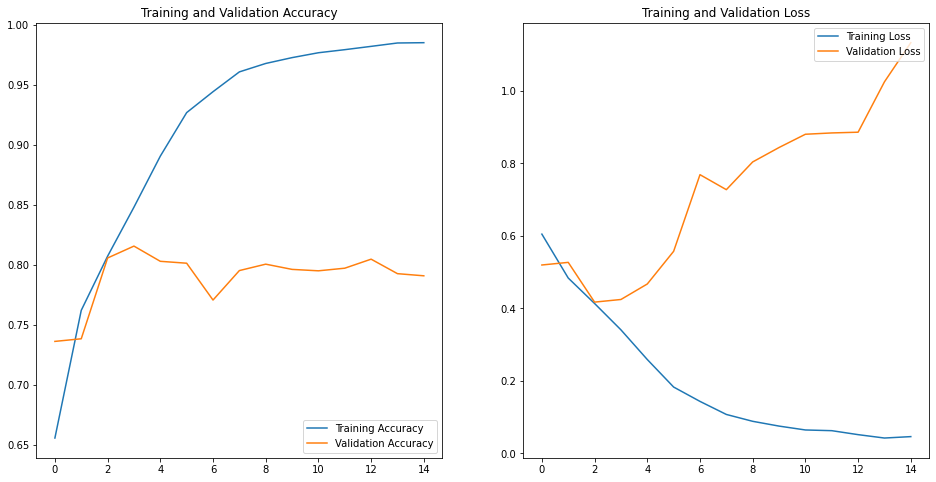

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Finally, let's use our model to classify an image that wasn't included in the training or validation sets.

In [18]:
class_names=  ['cats', 'dogs']

dog with a 99.96 percent confidence.


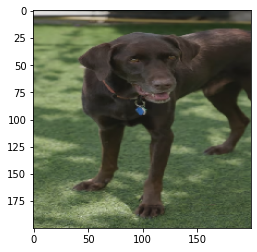

In [45]:
img = tf.keras.utils.load_img(
    'dog_1.PNG', target_size=(img_height, img_width)
) # note we set the image to the same height * width
img_array = tf.keras.utils.img_to_array(img)
plt.imshow(img_array/255.)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "{} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)][:-1], 100 * np.max(score))
)